In [1]:
!gdown "https://drive.google.com/u/0/uc?id=1mWl9Z6EKJDjlOdoPu5skp6uP39Ax4gME&export=download"

Downloading...
From: https://drive.google.com/u/0/uc?id=1mWl9Z6EKJDjlOdoPu5skp6uP39Ax4gME&export=download
To: /content/titanic.zip
100% 7.00k/7.00k [00:00<00:00, 10.2MB/s]


In [2]:
!unzip "titanic.zip"

Archive:  titanic.zip
  inflating: titanic_modified_dataset.csv  


In [3]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [23]:
class LogisticRegression():
  def __init__(self, batch_size, n_feature):
    self.batch_size = batch_size
    self.theta = np.random.normal(0, 0.1 , (n_feature + 1, 1))
    
  def sigmoid(self, z):
    return 1 / (1 + np.exp(-z))

  def loss(self, y, y_hat):
    return (- 1 / self.batch_size) * np.sum(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))

  def gradient(self, X, y, y_hat):
    return np.dot(X.T, (y_hat - y)) / self.batch_size 

  def predict(self, X):
    z = np.dot(X, self.theta)
    return self.sigmoid(z)

  def getBatchData(self, X, y, ith_iters):
    last_size = 0
    if len(X) % self.batch_size == 0:
      number_batch_size = int(len(X) / self.batch_size)
    else:
      number_batch_size = int(len(X) / self.batch_size) + 1
      last_size = len(X) - self.batch_size * number_batch_size

    ith_batch = ith_iters % number_batch_size

    if ith_batch == number_batch_size - 1 and last_size != 0:
      X_batch = X[ith_batch * self.batch_size : (ith_batch * self.batch_size) + last_size]
      y_batch = y[ith_batch * self.batch_size : (ith_batch * self.batch_size) + last_size]
    else:
      X_batch = X[ith_batch * self.batch_size : (ith_batch + 1) * self.batch_size]
      y_batch = y[ith_batch * self.batch_size : (ith_batch + 1) * self.batch_size]
    return X_batch, y_batch
  
  def accuracy(self, y, y_hat):
    y_hat = np.round(y_hat)
    return np.sum(y == y_hat) / len(y)

  def evaluate(self, x_val, y_val):
    y_hat = self.predict(x_val)
    y_hat = np.round(y_hat)
    return np.sum(y_val == y_hat) / len(y_val)

  def fit(self, X, y, n_iters, learning_rate):
    history = {"losses": [], "accs": []}
    for i in tqdm(range(n_iters)):
      # get X_batch, y_batch
      X_batch, y_batch = self.getBatchData(X, y, i)
      # calculate y_hat
      y_batch_hat = self.predict(X_batch)
      # calculate loss and append to list
      loss = self.loss(y_batch, y_batch_hat)
      history['losses'].append(loss)
      acc = self.accuracy(y_batch, y_batch_hat)
      history['accs'].append(acc)
      # calculate the gradient
      gradient = self.gradient(X_batch, y_batch, y_batch_hat)
      # update theta
      self.theta -= learning_rate * gradient
      print(f"epoch: {i}, loss: {loss}, acc: {acc}")
    return history


# Titanic data

In [5]:
path_csv = "titanic_modified_dataset.csv"
titanic_data_df = pd.read_csv(path_csv)
titanic_data_df

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Survived
0,1,3,0,22.0,1,0,7.2500,0,0,0
1,2,1,1,38.0,1,0,71.2833,1,1,1
2,3,3,1,26.0,0,0,7.9250,0,2,1
3,4,1,1,35.0,1,0,53.1000,0,1,1
4,5,3,0,35.0,0,0,8.0500,0,0,0
...,...,...,...,...,...,...,...,...,...,...
886,887,2,0,27.0,0,0,13.0000,0,5,0
887,888,1,1,19.0,0,0,30.0000,0,2,1
888,889,3,1,28.0,1,2,23.4500,0,2,0
889,890,1,0,26.0,0,0,30.0000,1,0,1


In [6]:
titanic_data_arr = titanic_data_df.to_numpy()

In [7]:
# devide features to X, label to y 
X = titanic_data_arr[:, 1 : 9]
y = titanic_data_arr[:, 9].reshape((-1, 1))
print(X.shape)
print(y.shape)

(891, 8)
(891, 1)


In [8]:
# add bias to X
bias = np.ones((X.shape[0], 1))
X = np.append(X, bias, axis=1)
print(X.shape)

(891, 9)


In [9]:
train_ratio = 0.7
validation_ratio = 0.2
test_ratio = 0.1

# train is now 75% of the entire data set
# the _junk suffix means that we drop that variable completely
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

print(x_train.shape, x_val.shape, x_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(623, 9) (178, 9) (90, 9)
(623, 1) (178, 1) (90, 1)


## Training

In [25]:
n_features = X.shape[1] - 1
n_iters = 100
np.random.seed(0)

### Batch_size = 1, learning_rate = 0.0001

In [26]:
batch_size = 1
learning_rate = 0.0001
LRModel = LogisticRegression(batch_size, n_features)
history = LRModel.fit(x_train, y_train, n_iters, learning_rate)

  0%|          | 0/100 [00:00<?, ?it/s]

epoch: 0, loss: 0.623019628011741, acc: 1.0
epoch: 1, loss: 1.8727384141000312, acc: 0.0
epoch: 2, loss: 0.07911892693971713, acc: 1.0
epoch: 3, loss: 2.041083040899157, acc: 0.0
epoch: 4, loss: 1.294679661083801, acc: 0.0
epoch: 5, loss: 4.00870956998381, acc: 0.0
epoch: 6, loss: 1.606632786367003, acc: 0.0
epoch: 7, loss: 1.3417964263598614, acc: 0.0
epoch: 8, loss: 1.6852680305518906, acc: 0.0
epoch: 9, loss: 0.1802105896325852, acc: 1.0
epoch: 10, loss: 0.5950340125404191, acc: 1.0
epoch: 11, loss: 0.08798697769834546, acc: 1.0
epoch: 12, loss: 0.11370417076328207, acc: 1.0
epoch: 13, loss: 0.155880304932642, acc: 1.0
epoch: 14, loss: 2.3025265533095087, acc: 0.0
epoch: 15, loss: 2.0944500484836888, acc: 0.0
epoch: 16, loss: 2.7520704899258726, acc: 0.0
epoch: 17, loss: 0.18944612124429905, acc: 1.0
epoch: 18, loss: 2.534054315930299, acc: 0.0
epoch: 19, loss: 2.1258668747020115, acc: 0.0
epoch: 20, loss: 0.11576417348117006, acc: 1.0
epoch: 21, loss: 2.0153592810234553, acc: 0.0
e

<function matplotlib.pyplot.show(*args, **kw)>

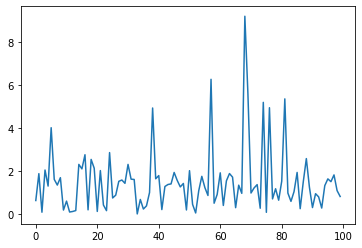

In [27]:
plt.plot(history['losses'])
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

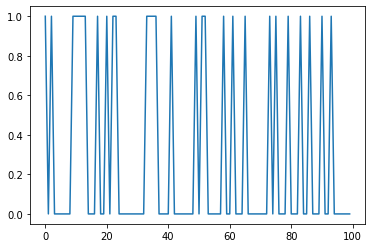

In [28]:
plt.plot(history['accs'])
plt.show

In [29]:
eval = LRModel.evaluate(x_val, y_val)
print(f"evaluatiotn: {eval}%")

evaluatiotn: 0.3202247191011236%


## batch_size = 32, learning_rate = 0.001

In [30]:
batch_size = 32
learning_rate = 0.001
LRModel = LogisticRegression(batch_size, n_features)
history = LRModel.fit(x_train, y_train, n_iters, learning_rate)

  0%|          | 0/100 [00:00<?, ?it/s]

epoch: 0, loss: 3.1880129696652464, acc: 0.3125
epoch: 1, loss: 3.0527125742535457, acc: 0.34375
epoch: 2, loss: 2.047926041357768, acc: 0.46875
epoch: 3, loss: 1.9472310910434332, acc: 0.40625
epoch: 4, loss: 1.490911262662057, acc: 0.40625
epoch: 5, loss: 1.642916577233673, acc: 0.25
epoch: 6, loss: 1.17293605709022, acc: 0.3125
epoch: 7, loss: 1.12205845191438, acc: 0.3125
epoch: 8, loss: 0.9410642481661979, acc: 0.28125
epoch: 9, loss: 0.7778660087454554, acc: 0.40625
epoch: 10, loss: 0.7339414554512651, acc: 0.5
epoch: 11, loss: 0.7332197582310791, acc: 0.5
epoch: 12, loss: 0.6514962652031987, acc: 0.5625
epoch: 13, loss: 0.6924629693113211, acc: 0.59375
epoch: 14, loss: 0.6645945760987417, acc: 0.71875
epoch: 15, loss: 0.6590249571421132, acc: 0.625
epoch: 16, loss: 0.5727320466093542, acc: 0.75
epoch: 17, loss: 0.7083690189270567, acc: 0.53125
epoch: 18, loss: 0.6628566221205796, acc: 0.5625
epoch: 19, loss: -0.0, acc: nan
epoch: 20, loss: 0.6392245296684027, acc: 0.6875
epoch: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in long_scalars


<function matplotlib.pyplot.show(*args, **kw)>

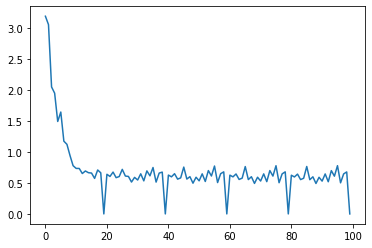

In [31]:
plt.plot(history['losses'])
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

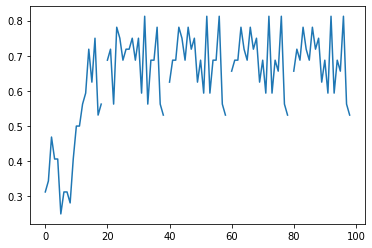

In [32]:
plt.plot(history['accs'])
plt.show

In [33]:
eval = LRModel.evaluate(x_val, y_val)
print(f"evaluatiotn: {eval}%")

evaluatiotn: 0.6853932584269663%


## batch_size = n_sample, learning_rate = 0.001

In [34]:
batch_size = len(x_train)
learning_rate = 0.001
LRModel = LogisticRegression(batch_size, n_features)
history = LRModel.fit(x_train, y_train, n_iters, learning_rate)

  0%|          | 0/100 [00:00<?, ?it/s]

epoch: 0, loss: 4.187469697113543, acc: 0.6115569823434992
epoch: 1, loss: 3.7216864099167157, acc: 0.6115569823434992
epoch: 2, loss: 3.258476466263805, acc: 0.6115569823434992
epoch: 3, loss: 2.79948136404755, acc: 0.6115569823434992
epoch: 4, loss: 2.3486668820236054, acc: 0.6147672552166934
epoch: 5, loss: 1.9351205569658427, acc: 0.6324237560192616
epoch: 6, loss: 1.6624814560075776, acc: 0.6404494382022472
epoch: 7, loss: 1.459831330055622, acc: 0.6468699839486356
epoch: 8, loss: 1.3102426790350015, acc: 0.651685393258427
epoch: 9, loss: 1.1995551783361806, acc: 0.6548956661316212
epoch: 10, loss: 1.1159030404041919, acc: 0.6548956661316212
epoch: 11, loss: 1.0512708338483872, acc: 0.6629213483146067
epoch: 12, loss: 1.0003605884342919, acc: 0.6693418940609952
epoch: 13, loss: 0.9595578192224058, acc: 0.6725521669341894
epoch: 14, loss: 0.9263636286014924, acc: 0.6773675762439807
epoch: 15, loss: 0.8989962615920383, acc: 0.6757624398073836
epoch: 16, loss: 0.8761439596645164, acc

<function matplotlib.pyplot.show(*args, **kw)>

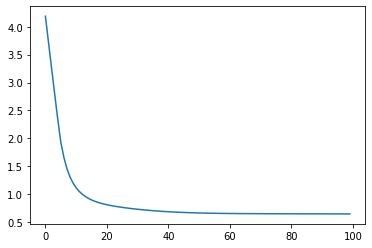

In [35]:
plt.plot(history['losses'])
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

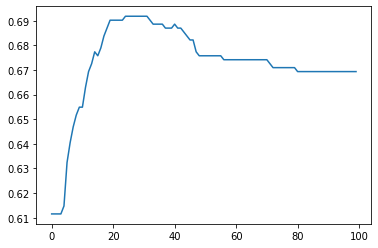

In [36]:
plt.plot(history['accs'])
plt.show

In [37]:
eval = LRModel.evaluate(x_val, y_val)
print(f"evaluatiotn: {eval}%")

evaluatiotn: 0.651685393258427%
